Пример на более крупной базе:

https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch

Более лаконичный пример на tf+keras

https://proproprogs.ru/neural_network/kak-delat-sentiment-analiz-rekurrentnoy-lstm-setyu

In [3]:
# !wget -r https://github.com/ankislyakov/data/raw/main/сентименты.xlsx

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
# на всякий случай проверим есть ли у нас GPU
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [7]:
df = pd.read_excel('github.com/ankislyakov/data/raw/main/сентименты.xlsx')
df.sample(5)

,review,sentiment
414,Ты обыкновенный неудачник,negative
487,Силы на исходе и терпение тоже,negative
476,много проблем,negative
103,"я не вижу препятствий, это очень легко",positive
489,Лежать в могиле это классно,negative


In [8]:
X,y = df['review'].values,df['sentiment'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size=0.33)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (410,)
shape of test data is (202,)


In [9]:
x_test = x_test[:-2]
y_test = y_test[:-2]

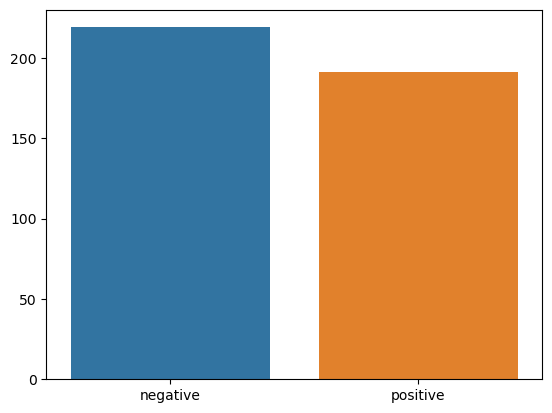

In [10]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [11]:
# пример функции для очистки нашего текста
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\ufeff", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    s = re.sub(r"\n", '', s)
    return s

In [12]:
word_list = []
for sent in x_train:
    for word in sent.lower().split():
        word = preprocess_string(word)
        word_list.append(word)
corpus = Counter(word_list)

corpus_ = sorted(corpus,key=corpus.get,reverse=True)
# создаем словарь
onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

In [13]:
final_list_train,final_list_test = [],[]
for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

encoded_train = [1 if label =='positive' else 0 for label in y_train]
encoded_test = [1 if label =='positive' else 0 for label in y_test]

In [14]:
print(f'Length of vocabulary is {len(onehot_dict)}')

Length of vocabulary is 1277


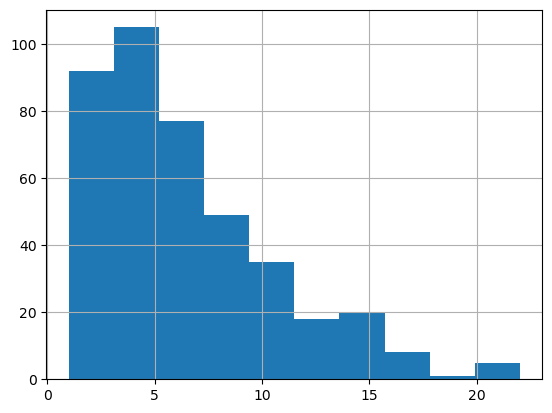

count    410.000000
mean       6.719512
std        3.978777
min        1.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       22.000000
dtype: float64

In [15]:
rev_len = [len(i) for i in final_list_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [16]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [17]:
#we have very less number of reviews with length > 10.
#So we will consideronly those below it.
x_train_pad = padding_(final_list_train,10)
x_test_pad = padding_(final_list_test,10)

In [18]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(np.array(encoded_train)))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(np.array(encoded_test)))

# dataloaders
batch_size = 10

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [19]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([10, 10])
Sample input: 
 tensor([[  80,  326,    2,  327,  328,  109,  159,  329,  330,   24],
        [   0,    0,    0,    0,    0,    0,  431,    4,  432,  433],
        [  12,    1,   82,  873,   22,   18,  255,    2,   21,  278],
        [   8,    1,  982,   14,    3,    4,  115,  983,    8,  984],
        [   0,    0,    0,    0,    8,    1,   47, 1251,   64, 1252],
        [ 101,  102,   14,  979,    4,  156,  980,   14,   11,  113],
        [   0,    0,    0,    0,  837,  838,    1,  839,   35,   96],
        [ 222,  262,   42,  224,  727,  728,  101,  102,  263,  264],
        [   0,    0,    0,    0,    0,   17,  627,  628,    2,  629],
        [  21,   12,   25,  363,    5,   17,   83,  364,  175,   81]])
Sample input: 
 tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1])


In [20]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # Слой эмбеддинга
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout()

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # получаем последнюю партию меток

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        # инициализация скрытого слоя
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [21]:
no_layers = 2
vocab_size = len(onehot_dict)+1
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1278, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [22]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [23]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # вычисляем accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` помогает предотвратить проблему взрывающегося градиента в RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}\n')

Epoch 1
train_loss : 0.6919279927160682 val_loss : 0.6738896280527115
train_accuracy : 60.97560975609756 val_accuracy : 58.5

Epoch 2
train_loss : 0.5779810475140084 val_loss : 0.6372132897377014
train_accuracy : 70.24390243902438 val_accuracy : 66.0

Epoch 3
train_loss : 0.4888522363290554 val_loss : 0.6749677956104279
train_accuracy : 79.26829268292683 val_accuracy : 65.0

Epoch 4
train_loss : 0.397732221135279 val_loss : 0.7238573014736176
train_accuracy : 84.8780487804878 val_accuracy : 65.0

Epoch 5
train_loss : 0.3096093013882637 val_loss : 0.7999509394168853
train_accuracy : 87.07317073170732 val_accuracy : 65.0

Epoch 6
train_loss : 0.20517312962470985 val_loss : 0.884890440106392
train_accuracy : 90.73170731707317 val_accuracy : 65.0

Epoch 7
train_loss : 0.1603411455161688 val_loss : 0.8630164310336113
train_accuracy : 94.39024390243902 val_accuracy : 67.5

Epoch 8
train_loss : 0.06931864110775655 val_loss : 1.2564659785479306
train_accuracy : 97.5609756097561 val_accuracy : 

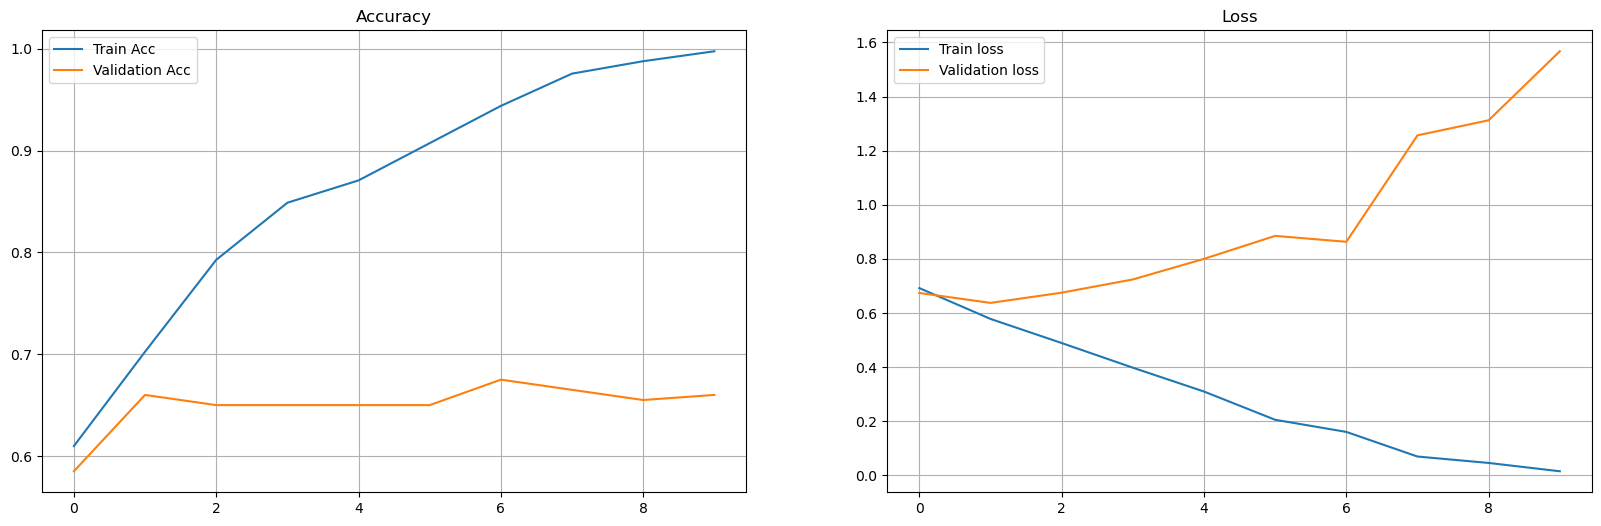

In [24]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [25]:
def predict_text(text):
        word_seq = np.array([onehot_dict[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in onehot_dict.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [26]:
index = np.random.randint(0,len(df))
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

не любила капусту
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.9994531463016756


In [27]:
# Собственный вариант
pro = predict_text('Люби всех!!!!!!!!!!')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.9526979327201843


In [28]:
word_list

['всегда',
 'делай',
 'то',
 'что',
 'ты',
 'боишься',
 'сделать',
 'оставайся',
 'позитивным',
 'прости',
 'других',
 'инвестируй',
 'в',
 'себя',
 'доверяй',
 'своим',
 'инстинктам',
 'на',
 'мгновение',
 'отвлекись',
 'от',
 'проблем',
 'и',
 'сосредоточься',
 'на',
 'положительных',
 'возможностях',
 'большие',
 'деньги',
 'честными',
 'не',
 'бывают',
 'я',
 'неудачник',
 'преподаватель',
 'по',
 'информатике',
 'не',
 'ставит',
 'автомат',
 'все',
 'лабораторные',
 'работы',
 'сданы',
 'на',
 'отлично',
 'позитивное',
 'мышление',
 'и',
 'визуализация',
 'моего',
 'успеха',
 'были',
 'моими',
 'ключами',
 'к',
 'успеху',
 'честные',
 'деньги',
 'не',
 'бывают',
 'большими',
 'хорошая',
 'погода',
 'и',
 'на',
 'душе',
 'светло',
 'у',
 'вас',
 'сегодня',
 'неудачный',
 'день',
 'если',
 'ты',
 'понимаешь',
 'что',
 'живешь',
 '',
 'это',
 'хорошо',
 'скоро',
 'лето',
 'и',
 'я',
 'очень',
 'рада',
 'чтобы',
 'добиться',
 'успеха',
 'в',
 'жизни',
 'нужно',
 'выиграть',
 'лишь',
 

В силу ограниченности количества фраз наш словарь не охватывает и 1% великого, могучего, правдивого и свободного русского языка, поэтому конечно же модель на фразах, состоящих из слов нашего словаря работают корректно. Однако и при этом семантика фразы не всегда корректна

In [29]:
# Собственный вариант
pro = predict_text('деньги и шопинг')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.9891406521201134


In [30]:
# А в какой фразе у нас это слово встречалось?
df[df['review'].str.contains('шопинг')]

,review,sentiment
335,Женщинам только и подавай: деньги и шопинг,negative


In [31]:
df[df['review'].str.contains('деньги')]

,review,sentiment
335,Женщинам только и подавай: деньги и шопинг,negative
354,Огромные деньги наживают только воровством,negative
355,Честные деньги не бывают большими,negative
364,"Почему такой умный, и такой бедный? Как только...",negative
368,Большие деньги честными не бывают,negative


In [32]:
# Собственный вариант
pro = predict_text('самое главное - это шопинг')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.999972939491272


In [33]:
df[df['review'].str.contains('самое главное')]

,review,sentiment
76,Одна вещь за один раз. Сначала самое главное. ...,positive
122,Моя семья-моё самое главное богатство.,positive


In [34]:
# Собственный вариант
pro = predict_text('самое главное - это деньги')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.9999433755874634


In [35]:
# Собственный вариант
pro = predict_text('самое главное')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.8455881774425507


In [36]:
# Собственный вариант: яркий пример того, что наша модель "слегка пессимистична"
# т.к. негативных фраз все-таки было чуть-чуть больше
# и те слова, которые модель "не знает" она чаще относит по умолчанию в негатив
pro = predict_text('биполярный транзистор')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.9435150995850563


In [37]:
# Собственный вариант: яркий пример того, что наша модель "слегка пессимистична"
# т.к. негативных фраз все-таки было чуть-чуть больше
# и те слова, которые модель "не знает" она относит по умолчанию в негатив
pro = predict_text('мама не сварила борщ')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.9981805704301223
